In [5]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
#import pymc as pm
#import arviz
import xarray as xr

from sklearn.linear_model import LinearRegression

import statsmodels as sm
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.metrics import explained_variance_score

#import bambi as bmb
seed = 73073

In [8]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [9]:
pwd="/home/mgcl/Escritorio/Sexto semestre/Taller de Ciencia de Datos/Bayesian Regression/allads.csv"
df=pd.read_csv(pwd)
df

,sales (millon$),ads(thousand$)
0,22.1,337.1
1,10.4,128.9
2,9.3,132.4
3,18.5,251.3
4,12.9,250.0
...,...,...
195,7.6,55.7
196,9.7,107.2
197,12.8,192.7
198,25.5,391.8


In [10]:
x= df.iloc[:, 1:].values
y = df.iloc[:, 0].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [11]:
np.shape(x_train)

(140, 1)

In [12]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [13]:
print('b1',lr.coef_,'b0',lr.intercept_)

b1 [0.04742327] b0 4.563993701626446


In [14]:
y_pred = lr.predict(x_test)


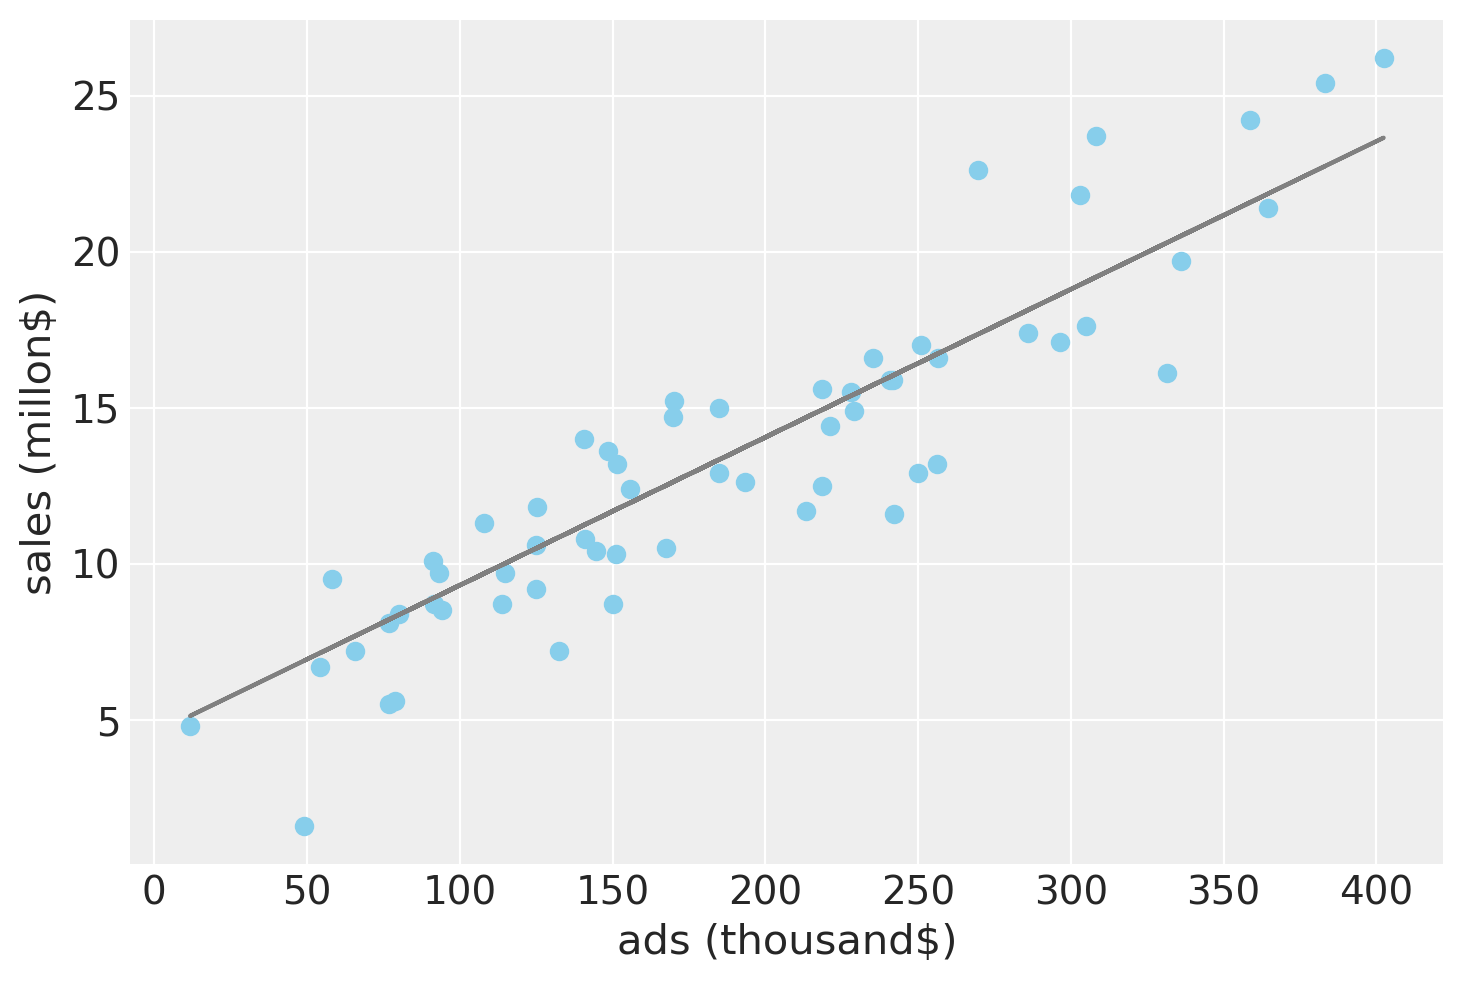

In [15]:
plt.plot(x_test, y_pred, color = 'grey')
plt.scatter(x_test, y_test, color = 'skyblue')
plt.title('')
plt.xlabel('ads (thousand$)')
plt.ylabel('sales (millon$)')
plt.show()

In [16]:

x = df.iloc[:, 1] # ads
y = df.iloc[:, 0] # sales

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

data_train = pd.DataFrame(dict(x=x_train, y=y_train),dtype=float)



# data=np.array(df)
# x = data[:, 1]  # ads
# y = data[:, 0]  # sales
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# np.shape(x_train)

In [17]:
with pm.Model() as model1:
    # prior distributions: Gaussian with very large variance
    intercept = pm.Normal('Intercept', 0, 10) # model b0 - Intercept Prior
    slope = pm.Normal('slope', 0, 10)         # model b1 - Slope Prior 
    sigma = pm.HalfNormal('sigma', 10)        # standard deviation
    x = pm.MutableData("x", data_train["x"])   
    # specify the model, linear regression
    mu = intercept + slope * x             # estimate of model
    y_obs= data_train["y"]
    # define the distribution of the predictions from the model and provide the data
    likelihood = pm.Normal('y', mu = mu, sigma = sigma, observed = y_obs, shape=mu.shape) # Observed values
    
    trace1=pm.sample(1000, chains=2, cores=2)
    
pm.summary(trace1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.547,0.586,3.497,5.645,0.020,0.014,877.0,854.0,1.0
slope,0.047,0.003,0.043,0.052,0.000,0.000,893.0,786.0,1.0
sigma,2.805,0.175,2.481,3.127,0.005,0.004,1190.0,982.0,1.0


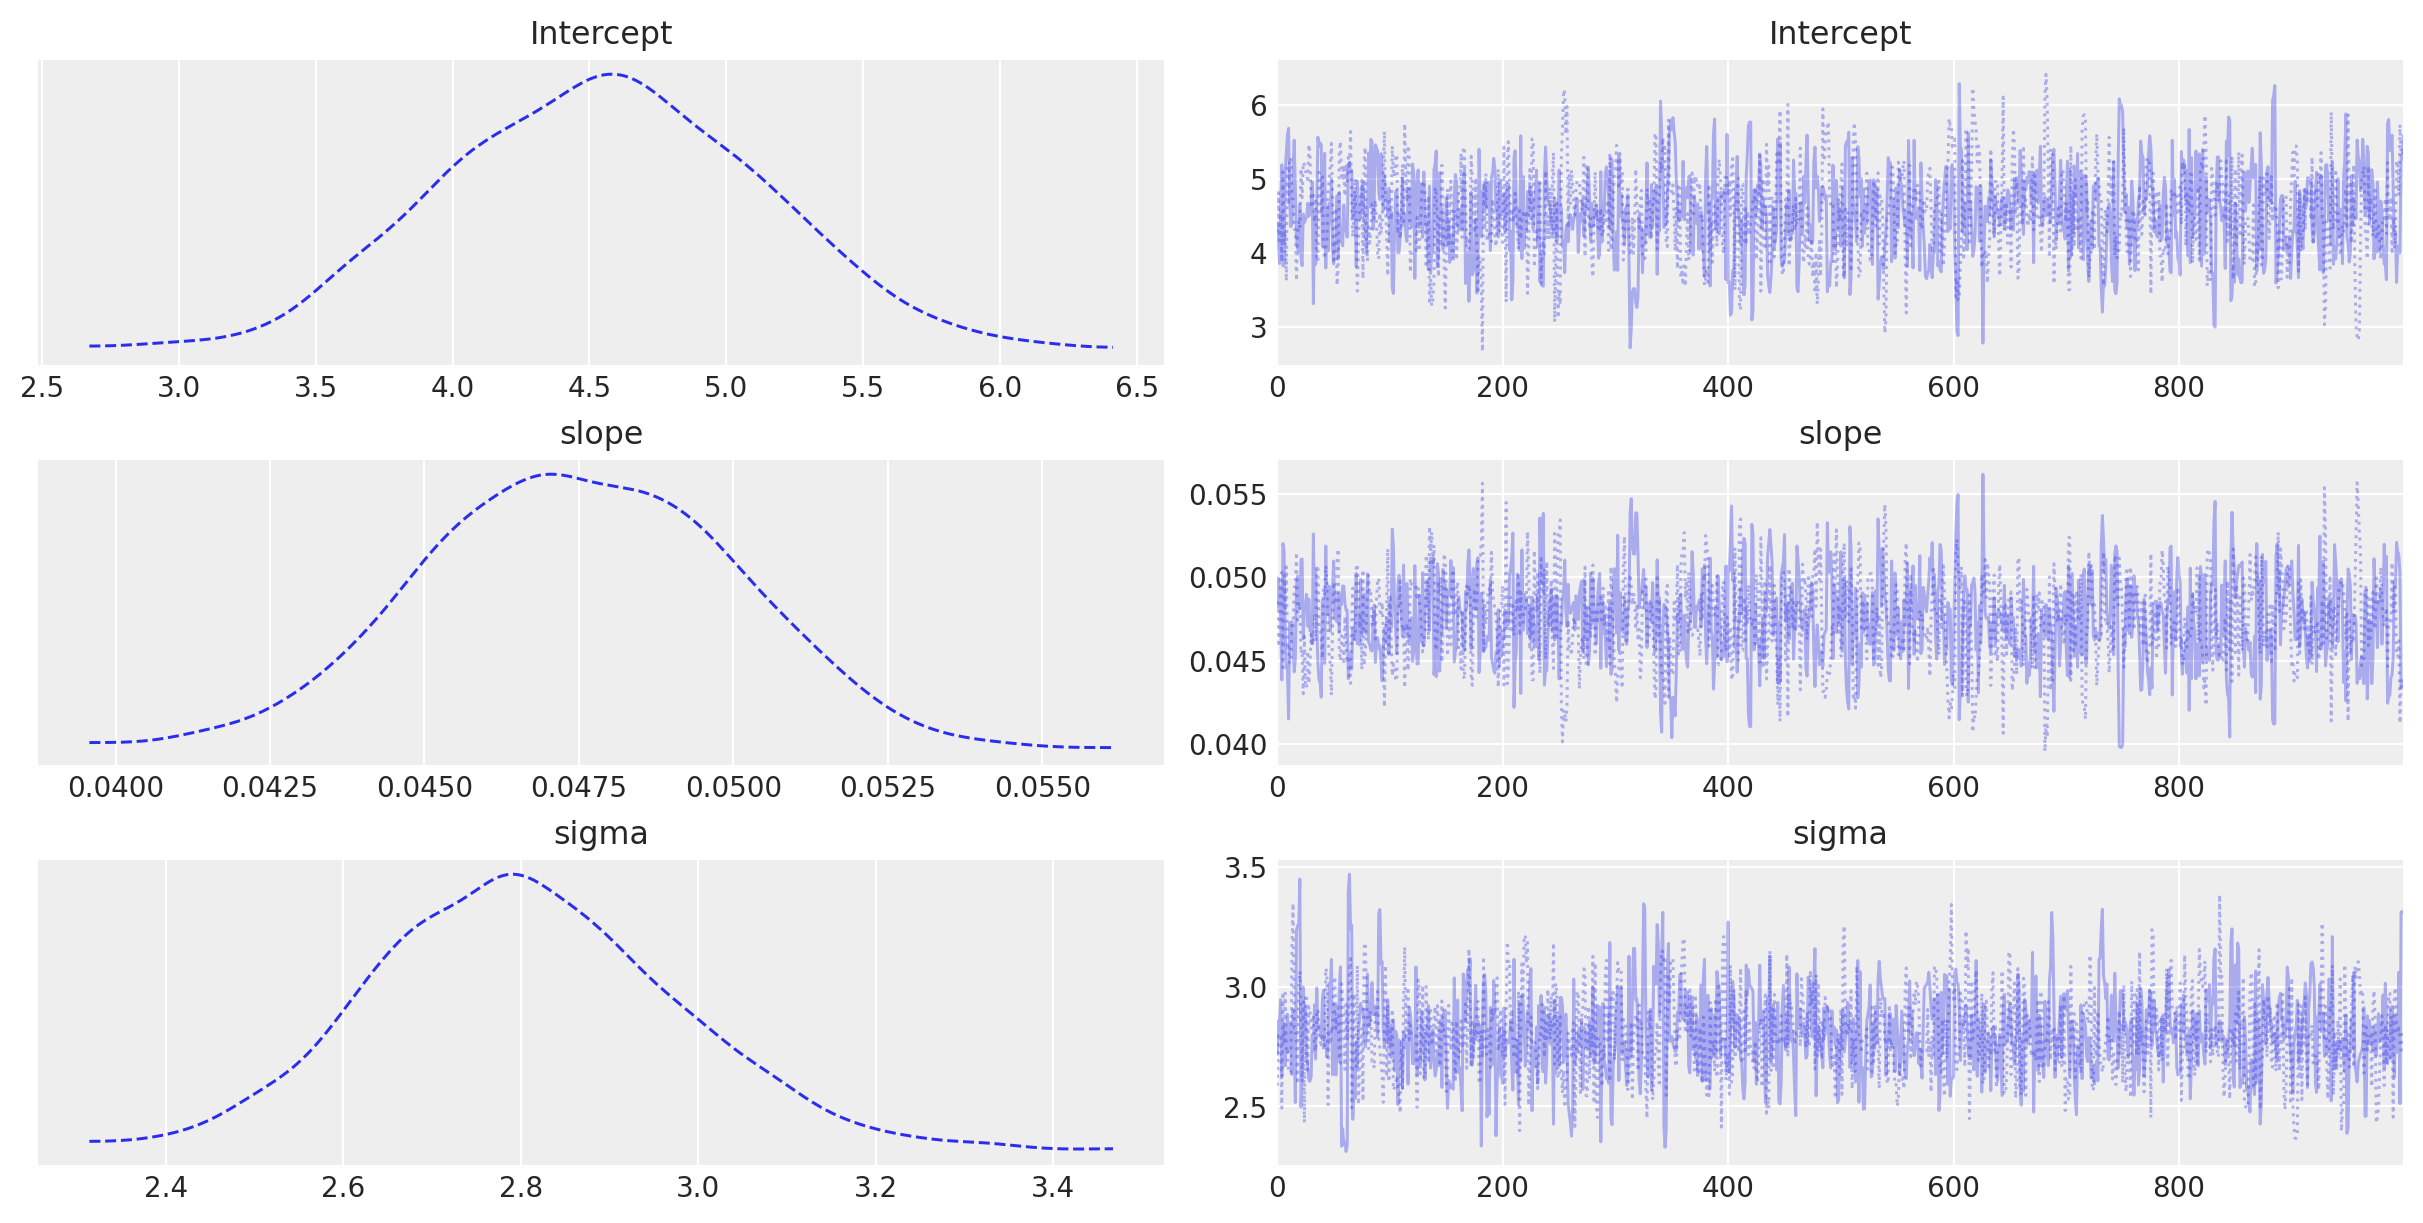

In [18]:
az.plot_trace(trace1, combined=True);

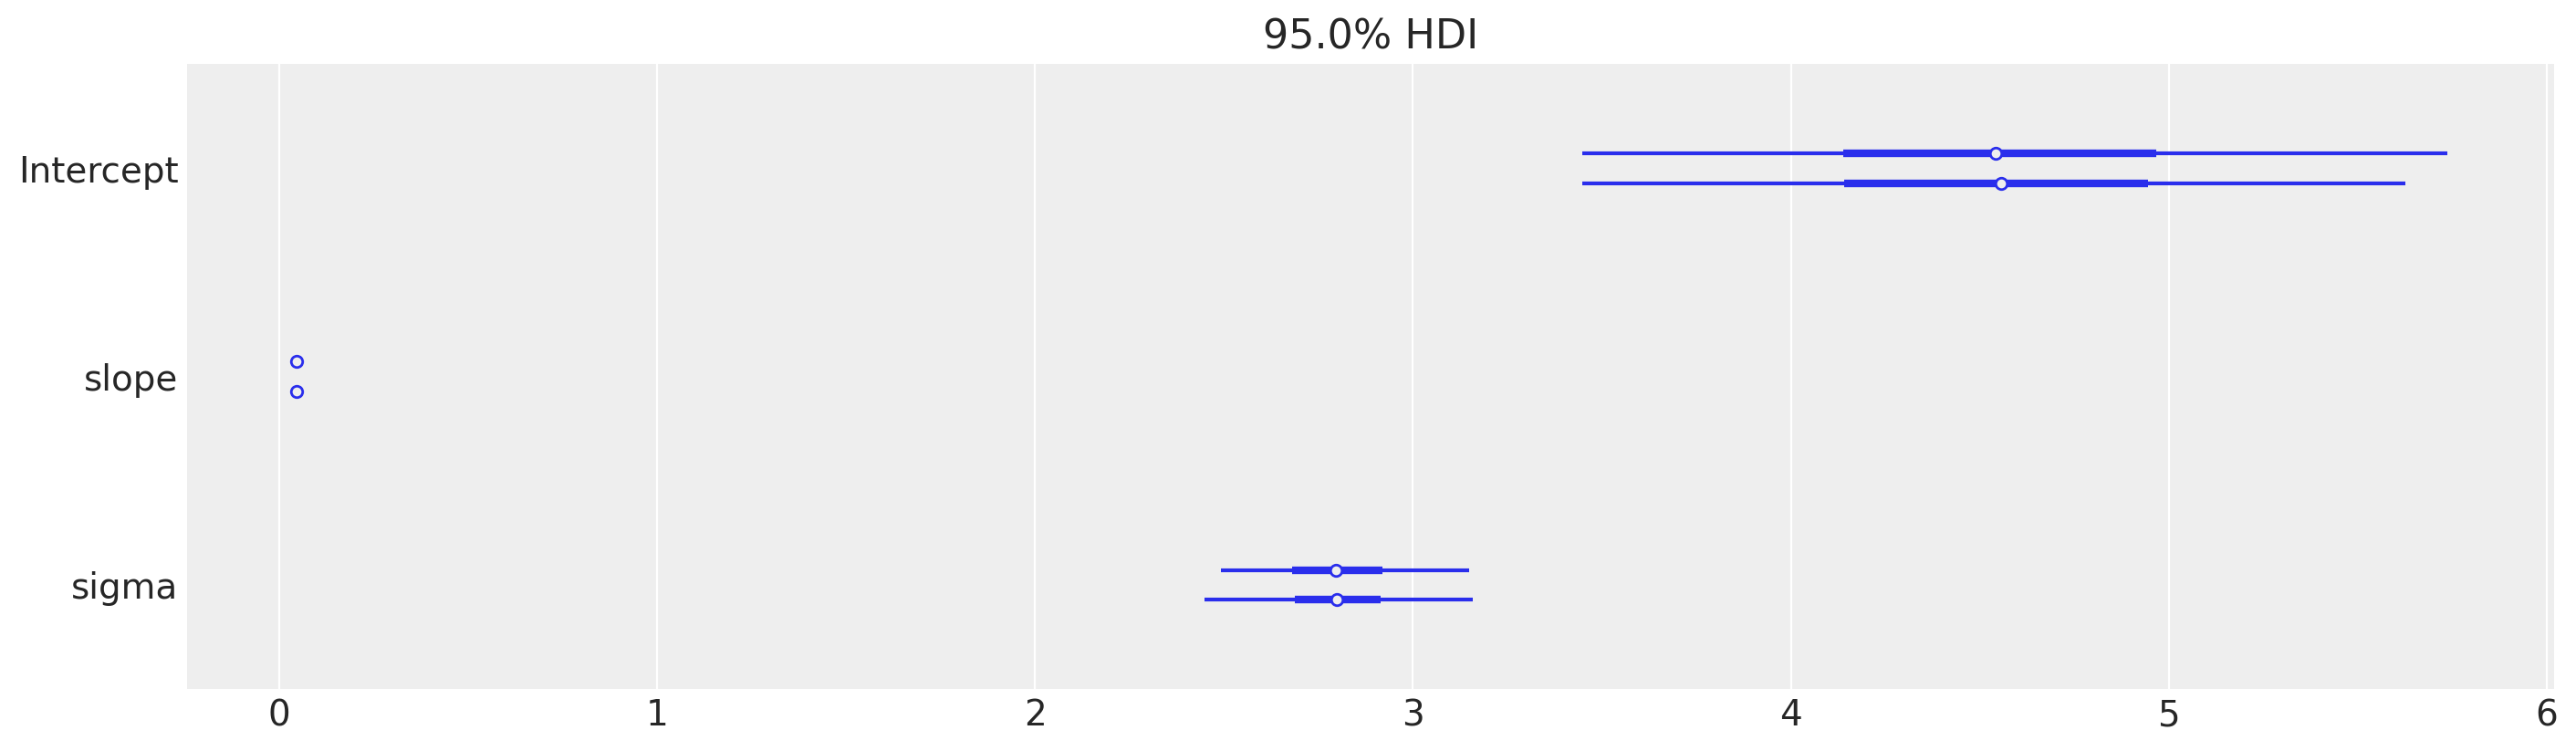

In [19]:
pm.plot_forest(trace1, hdi_prob = 0.95, figsize = (14,4));

In [20]:
x=xr.DataArray(data_train["x"])
trace1.posterior["ytrain_model"] = trace1.posterior["Intercept"] + trace1.posterior["slope"] * x


/home/mgcl/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


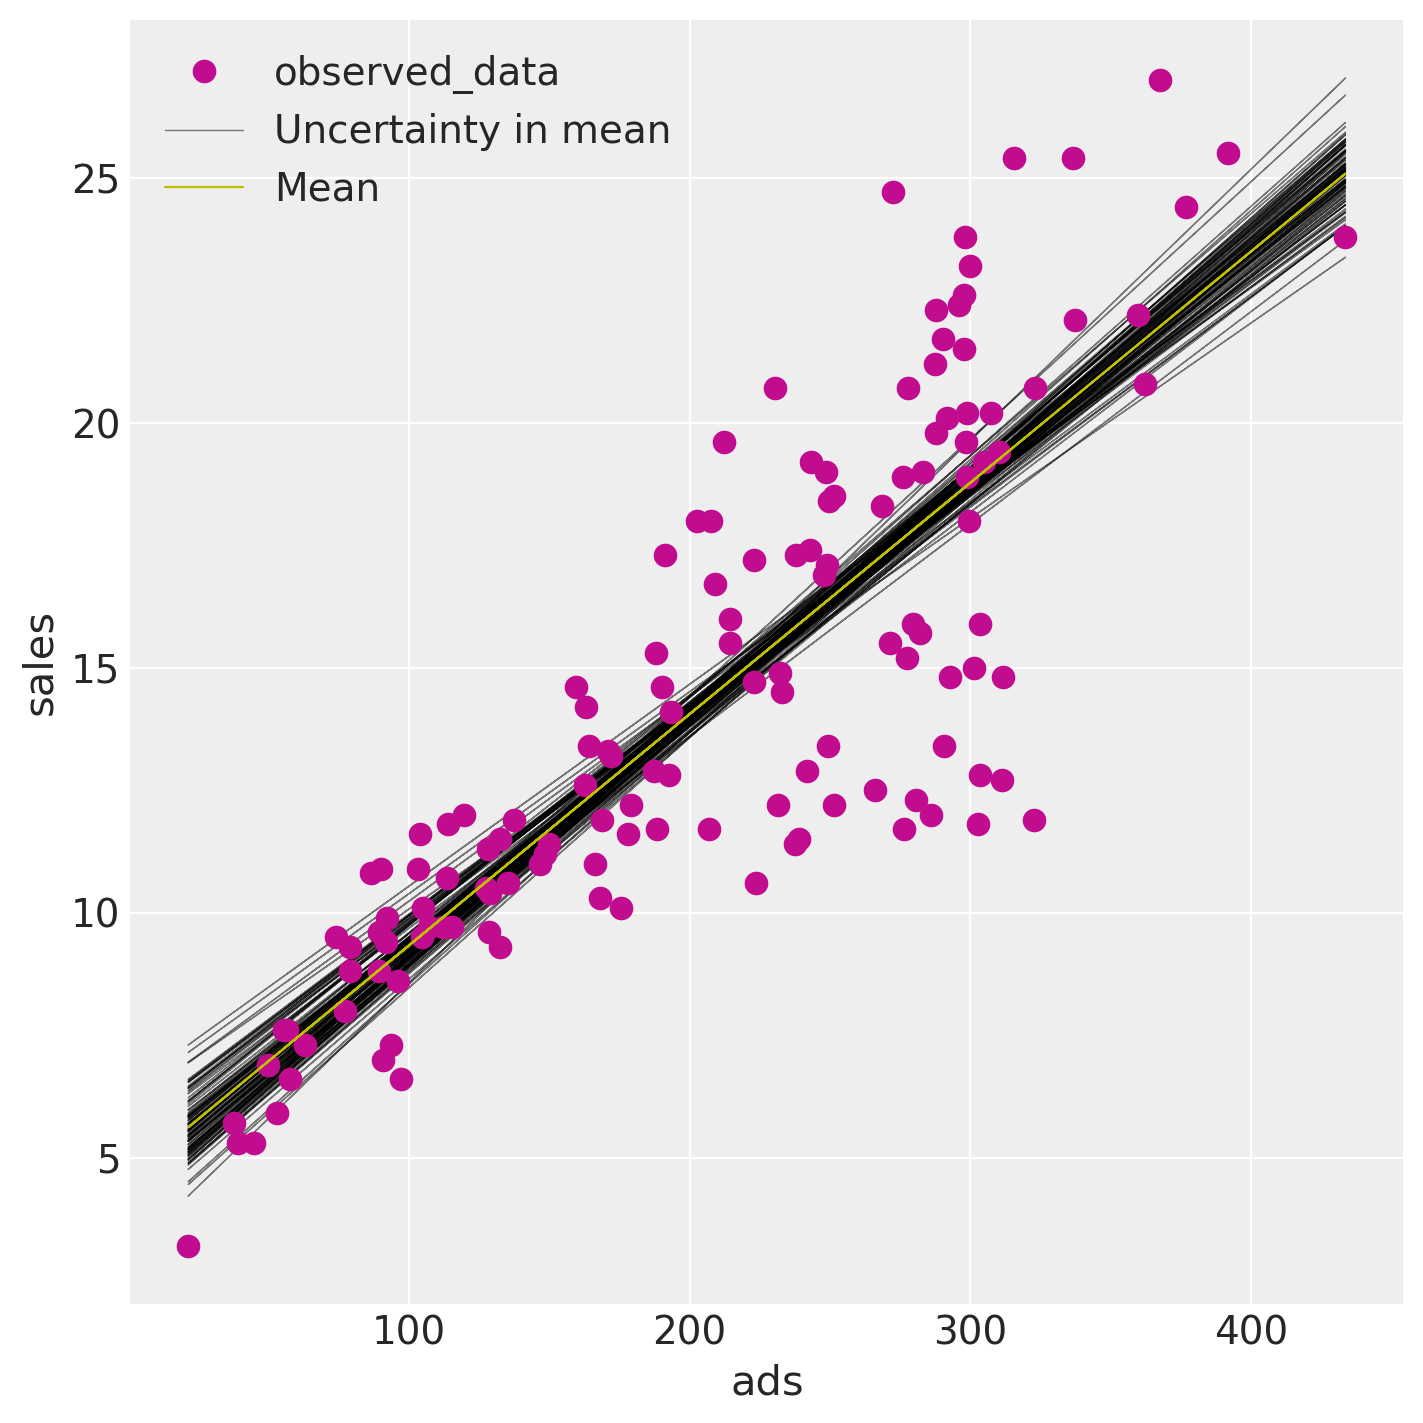

In [21]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=trace1, y="y", x=x, num_samples=100, axes=ax, y_model="ytrain_model");
ax.set_xlabel("ads");
ax.set_ylabel("sales");

In [28]:
import bambi as bmb

model1_bambi = bmb.Model('y ~ x', data_train)
# Fit the model using 1000 on each of 1 chains
results1_bambi = model1_bambi.fit(draws=1000, chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.57,0.58,3.48,5.67,0.01,0.01,5980.96,3215.13,1.0
x,0.05,0.00,0.04,0.05,0.00,0.00,6061.74,3281.68,1.0
y_sigma,2.80,0.17,2.50,3.12,0.00,0.00,5253.28,2986.63,1.0


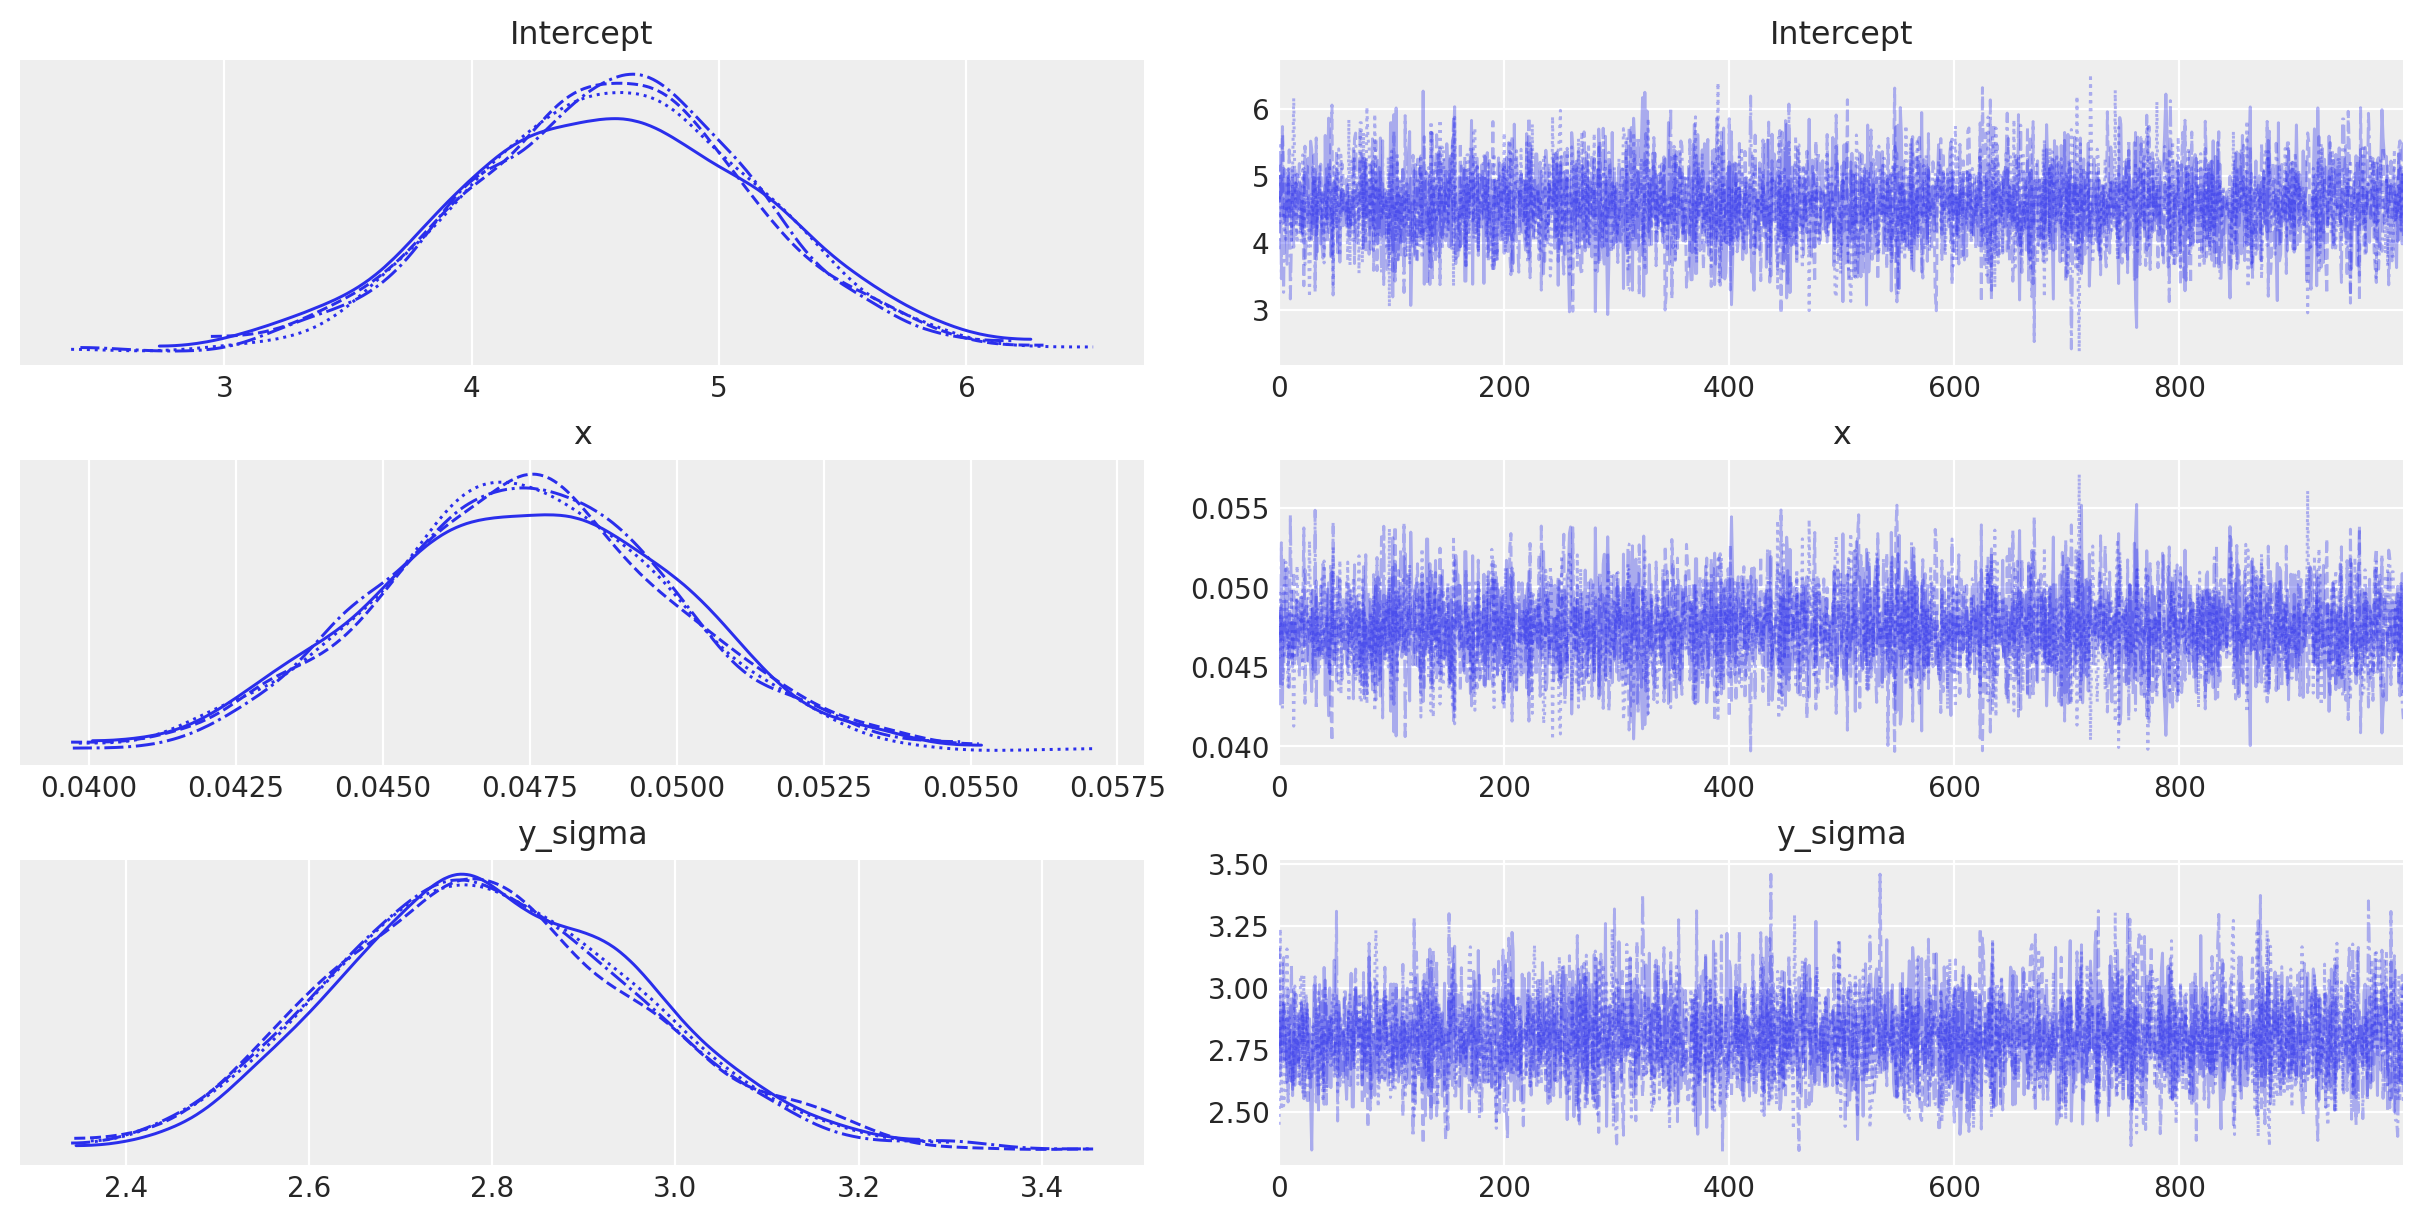

In [29]:
# Use ArviZ to plot the results
az.plot_trace(results1_bambi)

# Key summary and diagnostic info on the model parameters
az.summary(results1_bambi, round_to=2)